In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import torch.nn as nn

from neuralhydrology.utils.config import Config

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

import os

from neuralhydrology.modelzoo.cfe_modules.cfe_dataclasses import (
    GroundwaterStates,
    RoutingInfo,
    SoilConfig,
    SoilStates,
    get_constants,
)

from neuralhydrology.modelzoo.cfe_modules.get_default_params import get_default_params

# Validate Physics of CFE to C Code
The goal of this section is to compare the existing dCFE code (as of 20241215) to CFE hourly outputs: https://github.com/NWC-CUAHSI-Summer-Institute/cfe_py/blob/main/cat58_test_compare.csv The forcing for the same time period is: https://github.com/NWC-CUAHSI-Summer-Institute/cfe_py/blob/main/cat58_01Dec2015.csv The basin settings (since baasin id unknown) is here: https://github.com/NWC-CUAHSI-Summer-Institute/cfe_py/blob/main/bmi_cfe.py

Note that the forcing file as TMP_2maboveground which I assume is temperature in (K), so it needs to be converted to C before being used. And the initialized_basin_constants is adaped based on the bmi_cfe.py file.

In [2]:
# Set test data directory to NEURALHYDROLOGY-DCFE/test/test_data/cfe_data
test_data_dir = Path("/Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology-dcfe/test/test_data/cfe_data")

device = 'cpu'
batch_size = 2

forcingFile = pd.read_csv(test_data_dir/'cat58_01Dec2015.csv')
forcingsTest = torch.zeros(batch_size, forcingFile.shape[0], 3) #[ "batch_size", time_step, num_forcings]

forcingsTest[:, :, 0] = (torch.tensor(forcingFile.loc[:,'precip_rate']) * 1000 * 3600) # m/s to mm/hr
forcingsTest[:, :, 1] = (torch.tensor(forcingFile.loc[:,'TMP_2maboveground']) - 273.15) # K to C
forcingsTest[:, :, 2] = torch.tensor(forcingFile.loc[:,'DSWRF_surface']) # same unit as camels

# empty vector to store output
Discharge = torch.zeros(forcingsTest.shape[1], 8)

cfe_features = {
    'catchment_area_km2': 15.617167355002097 * torch.tensor(1.0, dtype=torch.float32, device=device).repeat(batch_size), 
    'refkdt': 3.8266861353378374 * torch.tensor(1.0, dtype=torch.float32, device=device).repeat(batch_size),
    'max_gw_storage': 16 * torch.tensor(1.0, dtype=torch.float32, device=device).repeat(batch_size),
    'Cgw': 0.01*torch.tensor(1.0).repeat(batch_size),
    'expon': 6.0 * torch.tensor(1.0, dtype=torch.float32, device=device).repeat(batch_size),
    'alpha_fc': 0.33 * torch.tensor(1.0, dtype=torch.float32, device=device).repeat(batch_size ),
    'K_nash': 0.03 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), 
    'K_lf': 0.01 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), 
    'nash_storage': torch.zeros((  batch_size,2), dtype=torch.float32, device= device),
    'giuh_ordinates': torch.tensor([[0.1, 0.35, 0.2, 0.14, 0.1, 0.06, 0.05], [0.1, 0.35, 0.2, 0.14, 0.1, 0.06, 0.05]], dtype=torch.float32, device= device),
    'depth': 2.0 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), # not sure where they got these values, they don't match CAMELS, [m]
    'bb': 4.05 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), # exponent on Clapp-Hornberger function, part of calibration
    'satdk': 0.00000338*torch.tensor(1.0).repeat(  batch_size),
    'satpsi': 0.355 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), 
    'slop': 1 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), # slope coefficient, part of calibration
    'smcmax': 0.439 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size), # maximum soil moisture content [m3/m3], part of calibration
    'wltsmc': 0.066* torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size),
    'D': 2.0 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size),
    'mult': 1000.0 * torch.tensor(1.0, dtype=torch.float32, device= device).repeat(  batch_size)
}

# Grab config file that trained this model
config_path = Path('/Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology-dcfe/examples/07-DCFE/2basinTest_devMultiBasin.yml')
config = Config(config_path, dev_mode=True)

cfe_params = get_default_params(config, cfe_features, device)
constants = get_constants(config.dcfe_hourly)

# initialize model states/reservoirs.
gw_reservoir = GroundwaterStates(device=device, batch_size=batch_size, cfe_params=cfe_params)
soil_config = SoilConfig(cfe_params=cfe_params, device=device, batch_size=batch_size, constants=constants)
soil_reservoir = SoilStates(
    device=device,
    batch_size=batch_size,
    cfe_params=cfe_params,
    soil_config=soil_config,
    constants=constants,
    )
routing_info = RoutingInfo(device=device, batch_size=batch_size, cfe_params=cfe_params)

#T-Shirt specific settings
gw_reservoir.storage_m = gw_reservoir.storage_max_m * 0.03125
soil_reservoir.storage_m = 0.667 * torch.tensor(1.0, dtype=torch.float32, device=device).repeat(batch_size)

from neuralhydrology.modelzoo.cfe_modules.timestep_cfe import timestep_cfe

for i in range(forcingsTest.shape[1]):

    cfe_params, gw_reservoir, soil_reservoir, routing_info, flux = timestep_cfe(
        x_conceptual_timestep=forcingsTest[:, i, :],
        cfe_params=cfe_params,
        timestep_params=None,
        gw_reservoir=gw_reservoir,
        soil_reservoir=soil_reservoir,
        soil_config=soil_config,
        routing_info=routing_info,
        constants=constants,
        )

    Discharge[i, 0] = flux.Qout_m[0]  # total discharge
    Discharge[i, 1] = flux.giuh_runoff_m[0] 
    Discharge[i, 2] = flux.nash_lateral_runoff_m[0]
    Discharge[i, 3] = flux.from_deep_gw_to_chan_m[0]
    Discharge[i, 4] = flux.surface_runoff_depth_m[0]
    Discharge[i, 5] = flux.actual_et_m_per_timestep[0] # total ET
    Discharge[i, 6] = soil_reservoir.storage_m[0] # soil water storage
    Discharge[i, 7] = gw_reservoir.storage_m[0] # gw storage

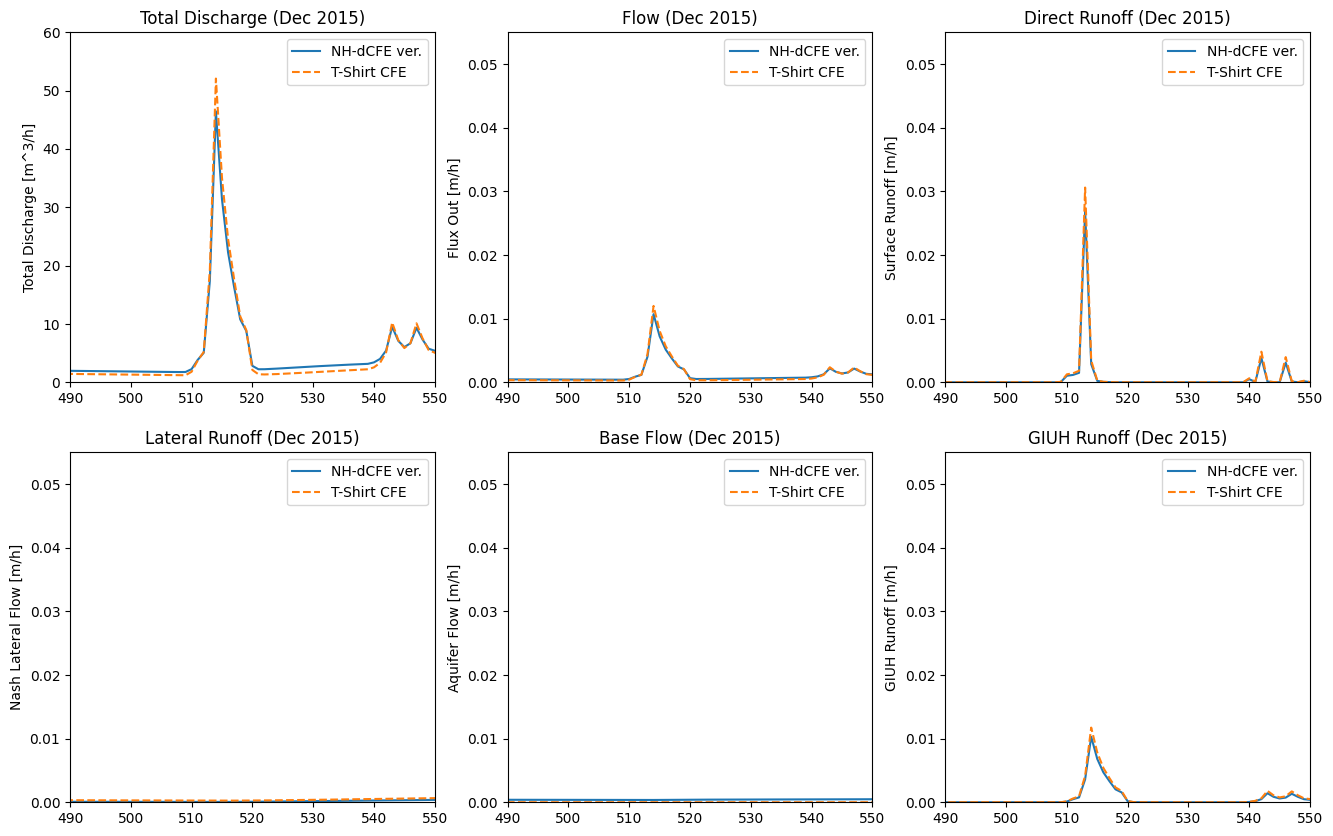

In [15]:
# grab observations from acutal CFE
compareFile = pd.read_csv(test_data_dir/'cat58_test_compare.csv')

fig, ax = plt.subplots(2, 3, figsize=(16,10))

ax[0,0].plot(compareFile['Time Step'], Discharge[:,0]*15.617167355002097 * 1000000.0 / 3600 , label="NH-dCFE ver.")
ax[0,0].plot(compareFile['Time Step'], compareFile['Total Discharge'], label="T-Shirt CFE", linestyle= 'dashed')
# Set labels and title
ax[0,0].set_ylabel("Total Discharge [m^3/h]")
ax[0,0].set_title(f"Total Discharge (Dec 2015)")
# Set axis limits
ax[0,0].set_xlim([490, 550]) 
ax[0,0].set_ylim([0, 60])  
ax[0,0].legend()

ax[0,1].plot(compareFile['Time Step'], Discharge[:,0], label="NH-dCFE ver.")
ax[0,1].plot(compareFile['Time Step'], compareFile['Flow'], label="T-Shirt CFE", linestyle= 'dashed')
# Set labels and title
ax[0,1].set_ylabel("Flux Out [m/h]")
ax[0,1].set_title(f"Flow (Dec 2015)")
# Set axis limits
ax[0,1].set_xlim([490, 550])  
ax[0,1].set_ylim([0, 0.055])  
ax[0,1].legend()

ax[0,2].plot(compareFile['Time Step'], Discharge[:,4], label="NH-dCFE ver.")
ax[0,2].plot(compareFile['Time Step'], compareFile['Direct Runoff'],label="T-Shirt CFE", linestyle = 'dashed')
# Set labels and title
ax[0,2].set_ylabel("Surface Runoff [m/h]")
ax[0,2].set_title(f"Direct Runoff (Dec 2015)")
# Set axis limits
ax[0,2].set_xlim([490, 550]) 
ax[0,2].set_ylim([0, 0.055])  
ax[0,2].legend()

ax[1,0].plot(compareFile['Time Step'], Discharge[:,2], label="NH-dCFE ver.")
ax[1,0].plot(compareFile['Time Step'], compareFile['Lateral Flow'],label="T-Shirt CFE", linestyle = 'dashed')
# Set labels and title
ax[1,0].set_ylabel("Nash Lateral Flow [m/h]")
ax[1,0].set_title(f"Lateral Runoff (Dec 2015)")
# Set axis limits
ax[1,0].set_xlim([490, 550]) 
ax[1,0].set_ylim([0, 0.055])   
ax[1,0].legend()

ax[1,1].plot(compareFile['Time Step'], Discharge[:,3], label="NH-dCFE ver.")
ax[1,1].plot(compareFile['Time Step'], compareFile['Base Flow'],label="T-Shirt CFE", linestyle = 'dashed')
# Set labels and title
ax[1,1].set_ylabel("Aquifer Flow [m/h]")
ax[1,1].set_title(f"Base Flow (Dec 2015)")
# Set axis limits
ax[1,1].set_xlim([490, 550]) 
ax[1,1].set_ylim([0, 0.055])  
ax[1,1].legend()

ax[1,2].plot(compareFile['Time Step'], Discharge[:,1], label="NH-dCFE ver.")
ax[1,2].plot(compareFile['Time Step'], compareFile['GIUH Runoff'], label="T-Shirt CFE", linestyle = 'dashed')
# Set labels and title
ax[1,2].set_ylabel("GIUH Runoff [m/h]")
ax[1,2].set_title(f"GIUH Runoff (Dec 2015)")
# Set axis limits
ax[1,2].set_xlim([490, 550]) 
ax[1,2].set_ylim([0, 0.055])   
ax[1,2].legend()

In [38]:
from neuralhydrology.evaluation.metrics import nse, mse

tot_discharge = compareFile['Total Discharge']
tot_discharge_sim = Discharge[:,0].numpy() * cfe_params.basin_characteristics.catchment_area_km2[0].numpy() * 1000000.0 / constants['time']['step_size']
np.sqrt(((tot_discharge[490:550] - tot_discharge_sim[490:550])**2).mean())


1.1711582187306486

In [ ]:
flow = compareFile['Flow']
flow_sim = Discharge[:,0].numpy()
np.sqrt(((flow[490:550] - flow_sim[490:550])**2).mean())

7.288785791786533e-08

In [ ]:
direct_runoff = compareFile['Direct Runoff']
direct_runoff_sim = Discharge[:,4].numpy()
np.sqrt(((direct_runoff[490:550] - direct_runoff_sim[490:550])**2).mean())

2.568582363264262e-07

In [ ]:
lateral_flow = compareFile['Lateral Flow']
lateral_flow_sim = Discharge[:,2].numpy()
np.sqrt(((lateral_flow[490:550] - lateral_flow_sim[490:550])**2).mean())

4.779476268469342e-08

In [ ]:
base_flow = compareFile['Base Flow']
base_flow_sim = Discharge[:,3].numpy()
np.sqrt(((base_flow[490:550] - base_flow_sim[490:550])**2).mean())

1.555899720686385e-07

In [37]:
giuh_runoff = compareFile['GIUH Runoff']
giuh_runoff_sim = Discharge[:,1].numpy()
np.sqrt(((giuh_runoff[490:550] - giuh_runoff_sim[490:550])**2).mean())

0.0002846503571328498